In [1]:
import os, shutil, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


2024-06-15 17:53:14.958233: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 17:53:14.958341: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 17:53:15.092473: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Define paths
base_dir = '/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/'
metadata_dir = '/kaggle/input/lfw-dataset'
output_dir = "/kaggle/working/"
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')

# Ensure the output directories exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Load metadata for splits
train_metadata = pd.read_csv(os.path.join(metadata_dir, 'peopleDevTrain.csv'))
test_metadata = pd.read_csv(os.path.join(metadata_dir, 'peopleDevTest.csv'))

# Function to normalize person names
def normalize_name(name):
    return '_'.join(name.replace('_', ' ').split()).strip()

# Function to copy images into training and testing folders
def prepare_dataset(df, img_folder, dest_folder):
    for index, row in df.iterrows():
        person_name = normalize_name(row['name'])
        images_count = int(row['images'])
        person_dir = os.path.join(dest_folder, person_name)  # Folder for the person
        os.makedirs(person_dir, exist_ok=True)

        # Format the image filename
        for i in range(1, images_count + 1):
            filename = f"{person_name}_{i:04d}.jpg"
            source_path = os.path.join(img_folder, person_name, filename)
            dest_path = os.path.join(person_dir, filename)

            # Check if the source file exists and copy
            if os.path.exists(source_path):
                shutil.copy(source_path, dest_path)

# Copy training images
prepare_dataset(train_metadata, base_dir, train_dir)
# Copy testing images
prepare_dataset(test_metadata, base_dir, test_dir)


In [3]:
# Function to count files in directories
def count_files(directory):
    """Count files in directories."""
    return sum(len(files) for _, _, files in os.walk(directory))

# Print counts to verify
print(f"Total training images: {count_files(train_dir)}")
print(f"Total testing images: {count_files(test_dir)}")

Total training images: 9525
Total testing images: 3708


In [4]:
# Function to create pairs and labels from matched and mismatched CSV files
def create_pairs_from_csv(match_csv, mismatch_csv, img_folder):
    """Create pairs and labels from CSV files."""
    pairs = []
    labels = []
    
    match_df = pd.read_csv(match_csv)
    mismatch_df = pd.read_csv(mismatch_csv)
    
    # Create positive pairs
    for _, row in match_df.iterrows():
        person_name = normalize_name(row['name'])
        img1 = f"{person_name}_{int(row['imagenum1']):04d}.jpg"
        img2 = f"{person_name}_{int(row['imagenum2']):04d}.jpg"
        pairs.append([os.path.join(img_folder, person_name, img1), os.path.join(img_folder, person_name, img2)])
        labels.append(1)
    
    # Create negative pairs
    for _, row in mismatch_df.iterrows():
        person1_name = normalize_name(row['name'])
        img1 = f"{person1_name}_{int(row['imagenum1']):04d}.jpg"
        person2_name = normalize_name(row['name.1'])
        img2 = f"{person2_name}_{int(row['imagenum2']):04d}.jpg"
        pairs.append([os.path.join(img_folder, person1_name, img1), os.path.join(img_folder, person2_name, img2)])
        labels.append(0)
    
    return np.array(pairs), np.array(labels)

# Load pairs from CSV files
train_match_csv = os.path.join(metadata_dir, 'matchpairsDevTrain.csv')
train_mismatch_csv = os.path.join(metadata_dir, 'mismatchpairsDevTrain.csv')
test_match_csv = os.path.join(metadata_dir, 'matchpairsDevTest.csv')
test_mismatch_csv = os.path.join(metadata_dir, 'mismatchpairsDevTest.csv')

train_pairs, train_labels = create_pairs_from_csv(train_match_csv, train_mismatch_csv, train_dir)
test_pairs, test_labels = create_pairs_from_csv(test_match_csv, test_mismatch_csv, test_dir)


In [5]:
# Check for class imbalance
print(f"Number of matched pairs in training set: {np.sum(train_labels == 1)}")
print(f"Number of mismatched pairs in training set: {np.sum(train_labels == 0)}")
print(f"Number of matched pairs in testing set: {np.sum(test_labels == 1)}")
print(f"Number of mismatched pairs in testing set: {np.sum(test_labels == 0)}")

Number of matched pairs in training set: 1100
Number of mismatched pairs in training set: 1100
Number of matched pairs in testing set: 500
Number of mismatched pairs in testing set: 500


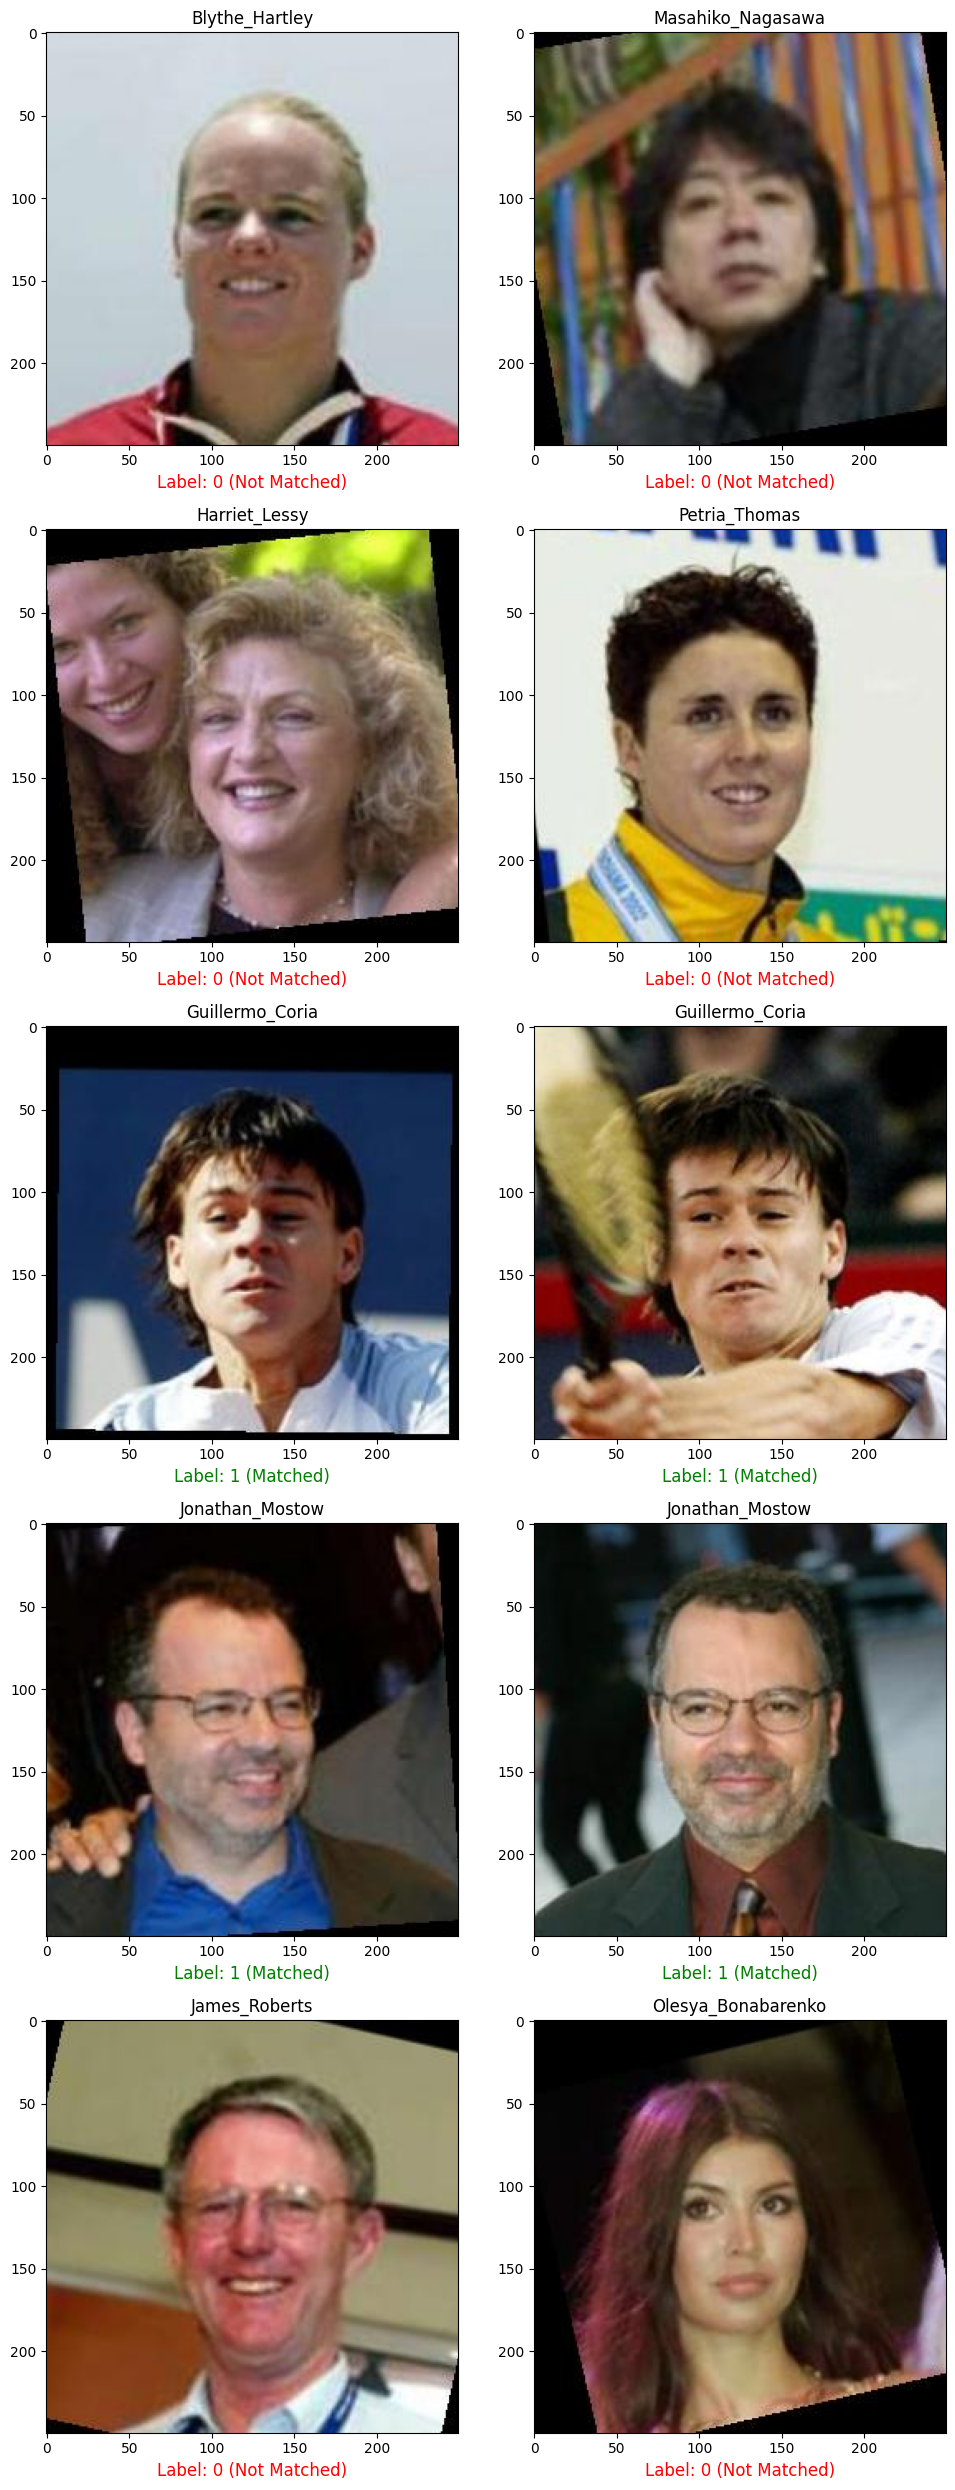

In [6]:
def visualize_random_pairs(pairs, labels, img_folder, num_pairs=5):
    fig, axes = plt.subplots(num_pairs, 2, figsize=(10, num_pairs * 5))
    
    for i in range(num_pairs):
        index = random.randint(0, len(pairs) - 1)
        pair = pairs[index]
        label = labels[index]

        # Extract person names from file paths
        person1_name = pair[0].split('/')[-2]
        person2_name = pair[1].split('/')[-2]

        # Load and plot first image
        img1 = plt.imread(pair[0])
        axes[i, 0].imshow(img1)
        axes[i, 0].set_title(person1_name)

        # Load and plot second image
        img2 = plt.imread(pair[1])
        axes[i, 1].imshow(img2)
        axes[i, 1].set_title(person2_name)

        # Set label
        if label == 1:
            label_text = 'Matched'
            color = 'green'
        else:
            label_text = 'Not Matched'
            color = 'red'

        # Print label
        axes[i, 0].set_xlabel(f'Label: {label} ({label_text})', color=color, fontsize=12)
        axes[i, 1].set_xlabel(f'Label: {label} ({label_text})', color=color, fontsize=12)

    plt.tight_layout()
    plt.show()

        
    
# Visualize random pairs
visualize_random_pairs(train_pairs, train_labels, train_dir)


In [60]:
# Modify preprocess_image function to ensure RGB format is maintained
def preprocess_image(image_path, target_size=(128, 128)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    # Ensure RGB format
    if image.shape[2] == 1:  # Convert grayscale to RGB
        image = np.concatenate([image] * 3, axis=2)
    # Normalize to [0, 1]
    image = image / 255.0
    return image

def load_and_preprocess_pairs(pairs):
    processed_pairs = []
    for pair in pairs:
        img1 = preprocess_image(pair[0])
        img2 = preprocess_image(pair[1])
        processed_pairs.append([img1, img2])
    return np.array(processed_pairs)

train_pairs_processed = load_and_preprocess_pairs(train_pairs)
test_pairs_processed = load_and_preprocess_pairs(test_pairs)

In [99]:
from keras.layers import Input, Concatenate, Subtract, Multiply, Dense, Dropout

# Define VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the layers
for layer in base_model.layers:
    layer.trainable = False

# Define the Siamese network
input_1 = Input(shape=(128, 128, 3))
input_2 = Input(shape=(128, 128, 3))

# Use the same base model for both inputs
processed_1 = base_model(input_1)
processed_2 = base_model(input_2)

# Flatten the output
flatten_1 = Flatten()(processed_1)
flatten_2 = Flatten()(processed_2)

# Calculate L1 distance between the two flattened embeddings
l1_distance = Subtract()([flatten_1, flatten_2])
l1_distance = Multiply()([l1_distance, l1_distance])  # Element-wise multiplication
l1_distance = Dense(512, activation='relu')(l1_distance)
l1_distance = Dropout(0.5)(l1_distance)
l1_distance = Dense(256, activation='relu')(l1_distance)
l1_distance = Dropout(0.5)(l1_distance)
output = Dense(1, activation='sigmoid')(l1_distance)

# Create the Siamese model
siamese_model = Model(inputs=[input_1, input_2], outputs=output)

# Compile the model
siamese_model.compile(loss='binary_crossentropy',
                       optimizer=Adam(learning_rate=0.001),
                       metrics=['accuracy'])

# Display model summary
siamese_model.summary()

Model: "functional_46"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_62      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_63      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 4, 4, 512) │ 14,714,688 │ input_layer_62[0… │
│                     │                   │            │ input_layer_63[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_40          │ (None, 8192)      │          0 │ vgg16[0][0]       │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_41          │ (None, 8192)      │          0 │ vgg16[1][0]       │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 8192)      │          0 │ flatten_40[0][0], │
│                     │                   │            │ flatten_41[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 8192)      │          0 │ subtract[0][0],   │
│                     │                   │            │ subtract[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_61 (Dense)    │ (None, 512)       │  4,194,816 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 512)       │          0 │ dense_61[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_62 (Dense)    │ (None, 256)       │    131,328 │ dropout_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 256)       │          0 │ dense_62[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_63 (Dense)    │ (None, 1)         │        257 │ dropout_21[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,041,089 (72.64 MB)

 Trainable params: 4,326,401 (16.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [100]:
checkpoint = ModelCheckpoint('siamese_model.h5', save_best_only=True, monitor='val_loss')
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model
history = siamese_model.fit(
    [train_pairs_processed[:, 0], train_pairs_processed[:, 1]], train_labels,
    validation_data=([test_pairs_processed[:, 0], test_pairs_processed[:, 1]], test_labels),
    batch_size=16, 
    epochs=20,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/20
  7/138 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5821 - loss: 0.9830

W0000 00:00:1718478255.685129      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5093 - loss: 1.5181

W0000 00:00:1718478265.301253      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


138/138 ━━━━━━━━━━━━━━━━━━━━ 19s 90ms/step - accuracy: 0.5092 - loss: 1.6344 - val_accuracy: 0.5370 - val_loss: 7.4430
Epoch 2/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.5531 - loss: 0.9933 - val_accuracy: 0.6020 - val_loss: 9.2003
Epoch 3/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.5927 - loss: 0.9117 - val_accuracy: 0.5890 - val_loss: 22.2782
Epoch 4/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.6351 - loss: 2.7728 - val_accuracy: 0.5400 - val_loss: 361.1693
Epoch 5/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.6282 - loss: 4.6441 - val_accuracy: 0.6060 - val_loss: 0.6616
Epoch 6/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.7095 - loss: 8.3149 - val_accuracy: 0.5650 - val_loss: 807.3627
Epoch 7/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.6745 - loss: 3.9373 - val_accuracy: 0.6210 - val_loss: 0.6614
Epoch 8/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7287 - loss: 4.6553 - val_accuracy

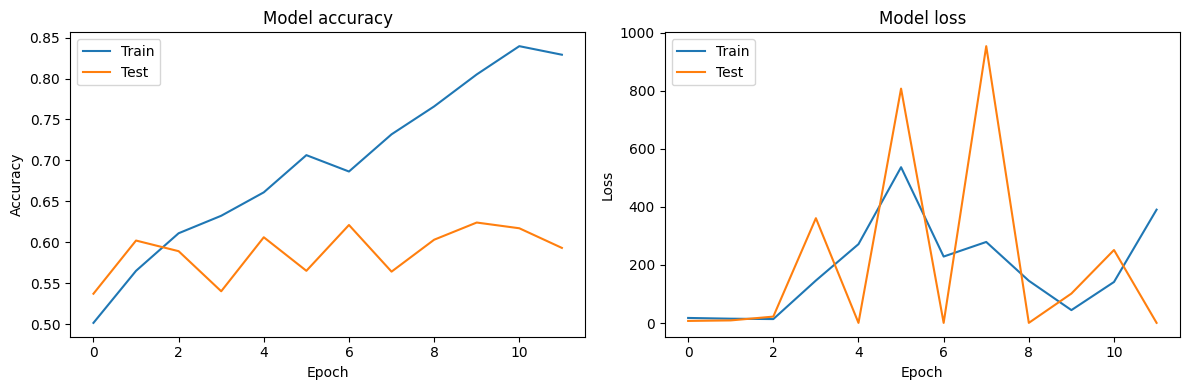

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6554 - loss: 0.6875
Test Loss: 0.7727
Test Accuracy: 0.5930


In [102]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

# Evaluate on test data
test_loss, test_accuracy = siamese_model.evaluate(
    [test_images_A, test_images_B], test_labels,
    batch_size=16 
)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')



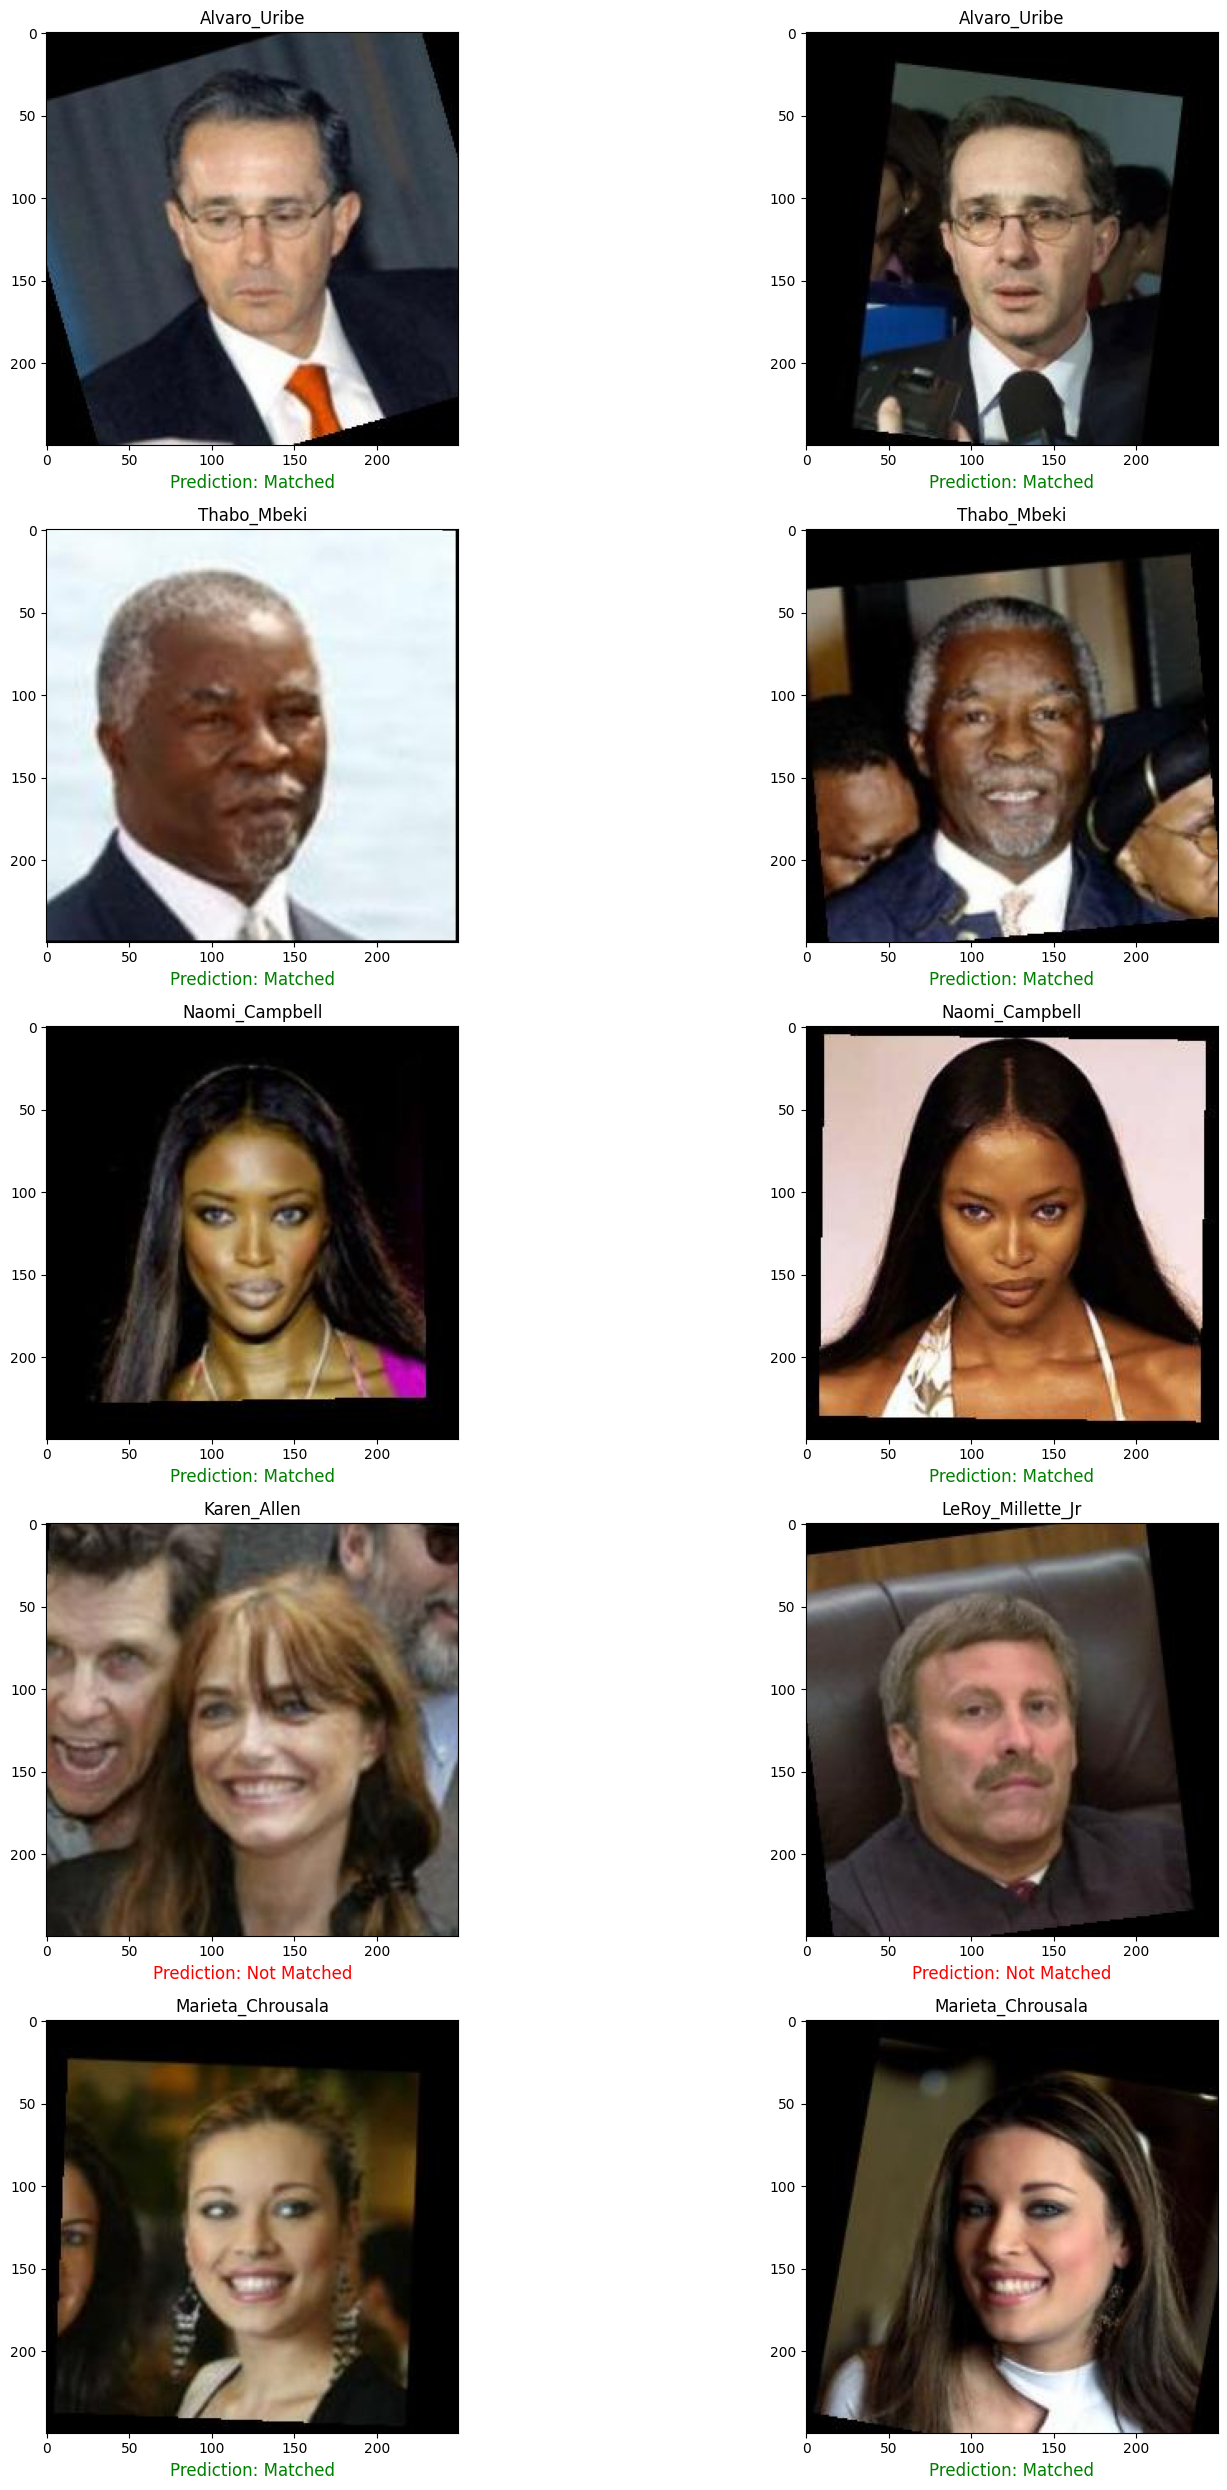

In [123]:
import random
import matplotlib.pyplot as plt

def visualize_test_pairs_with_predictions(model, test_pairs, test_labels, num_pairs=5):
    fig, axes = plt.subplots(num_pairs, 2, figsize=(18, num_pairs * 5))
    
    for i in range(num_pairs):
        index = random.randint(0, len(test_pairs) - 1)
        pair = test_pairs[index]
        label = test_labels[index]

        # Load and plot first image
        img1 = plt.imread(pair[0])
        axes[i, 0].imshow(img1)
        person1_name = pair[0].split('/')[-2]
        axes[i, 0].set_title(person1_name)

        # Load and plot second image
        img2 = plt.imread(pair[1])
        axes[i, 1].imshow(img2)
        person2_name = pair[1].split('/')[-2] 
        axes[i, 1].set_title(person2_name)

        # Determine if they are matched or not
        if label == 1:
            prediction_text = 'Matched'
            color = 'green'
        else:
            prediction_text = 'Not Matched'
            color = 'red'

        # Print prediction as title
        axes[i, 0].set_xlabel(f'Prediction: {prediction_text}', color=color, fontsize=12)
        axes[i, 1].set_xlabel(f'Prediction: {prediction_text}', color=color, fontsize=12)

    plt.tight_layout()
    plt.show()

# Visualize random test pairs with predictions
visualize_test_pairs_with_predictions(siamese_model, test_pairs, test_labels)


In [126]:
pip install tf2onnx


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [128]:
siamese_model.save("siamese_model.h5")

In [131]:
import tf2onnx
import tensorflow as tf

# Load the saved Keras model
keras_model = tf.keras.models.load_model('siamese_model.h5')

# Convert the Keras model to ONNX
onnx_model_path = 'siamese_model.onnx'
spec = (tf.TensorSpec((None, 128, 128, 3), tf.float32, name="input_1"), tf.TensorSpec((None, 128, 128, 3), tf.float32, name="input_2"))
model_proto, _ = tf2onnx.convert.from_keras(keras_model, input_signature=spec, opset=13)
with open(onnx_model_path, "wb") as f:
    f.write(model_proto.SerializeToString())